Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


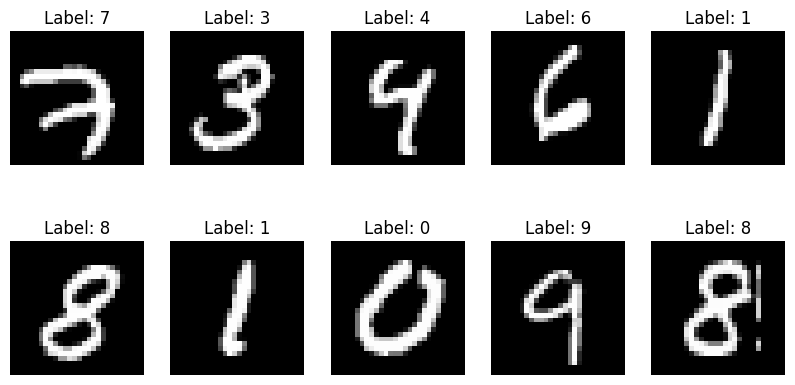

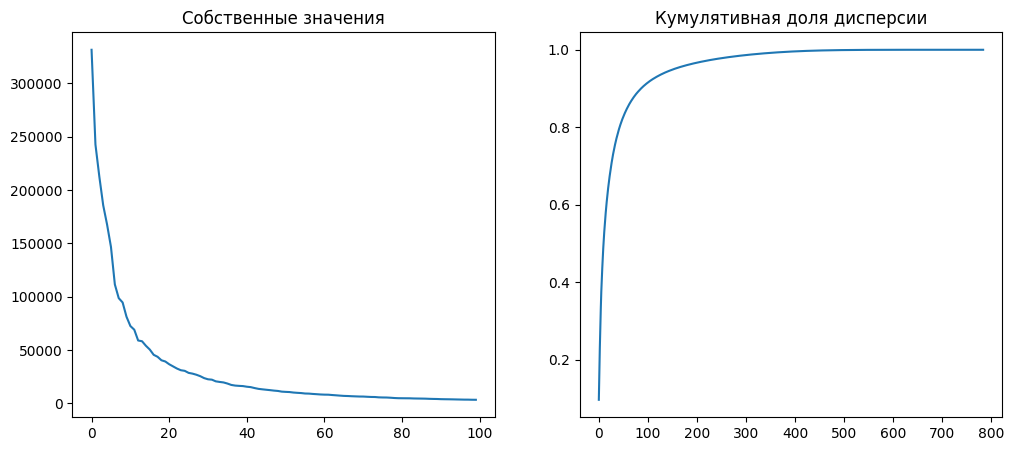

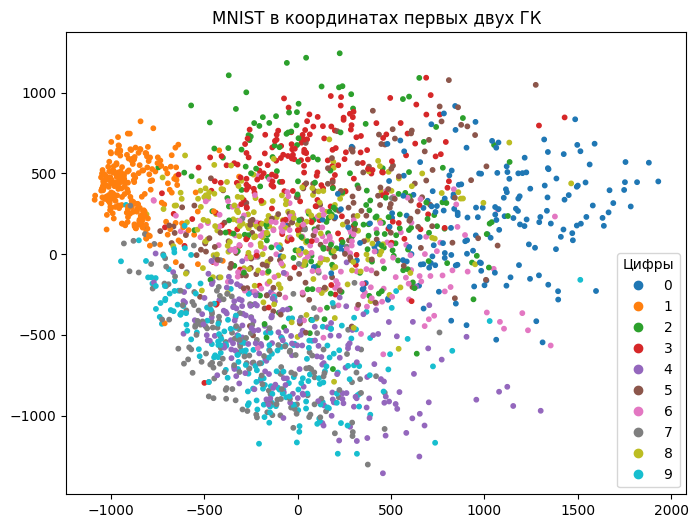

Точность: 0.9741818181818181


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mnist import load_mnist

train, validation, test = load_mnist()

X, y = train

X = X.reshape(X.shape[0], -1)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y[i]}")
    ax.axis("off")
plt.show()

class my_PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        cov_matrix = np.cov(X_centered, rowvar=False)

        eigvals, eigvecs = np.linalg.eigh(cov_matrix)

        sorted_idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[sorted_idx]
        eigvecs = eigvecs[:, sorted_idx]

        self.explained_variance_ = eigvals
        self.components_ = eigvecs[:, :self.n_components]

    def transform(self, X):
        X_centered = X - self.mean_
        return np.dot(X_centered, self.components_)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


class my_KNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            idxs = np.argsort(distances)[:self.n_neighbors]
            neighbor_labels = self.y_train[idxs]
            labels, counts = np.unique(neighbor_labels, return_counts=True)
            y_pred.append(labels[np.argmax(counts)])
        return np.array(y_pred)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#PCA
pca = my_PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(pca.explained_variance_[:100])
plt.title("Собственные значения")

plt.subplot(1, 2, 2)
plt.plot(np.cumsum(pca.explained_variance_) / np.sum(pca.explained_variance_))
plt.title("Кумулятивная доля дисперсии")
plt.show()

#2D
pca_2d = my_PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train[:2000])
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train[:2000], cmap="tab10", s=10)
plt.legend(*scatter.legend_elements(), title="Цифры")
plt.title("MNIST в координатах первых двух ГК")
plt.show()

knn = my_KNN(n_neighbors=5)
knn.fit(X_train_pca, y_train)
y_pred = knn.predict(X_test_pca)

print("Точность:", accuracy_score(y_test, y_pred))
